In [138]:
from xgboost import XGBClassifier
import pandas as pd
from rdkit import Chem
from descriptastorus.descriptors.DescriptorGenerator import MakeGenerator
from tqdm.notebook import tqdm
from sklearn.model_selection import train_test_split
import numpy as np
import seaborn as sns
from sklearn.metrics import roc_auc_score
from sklearn.utils import resample

Read the antibacterial data from the supporting material from Stokes et al into a dataframe

In [79]:
ab_df = pd.read_excel("mmc1.xlsx",sheet_name=1,skiprows=1)

In order to be consistent with previous notebooks, set active and inactive to 1 and 0

In [81]:
ab_df['active'] = [int(x == "Active") for x in ab_df.Activity]

In [82]:
ab_df.head()

,Mean_Inhibition,SMILES,Name,Activity,active
0,0.041572,Cc1cc(O)c(C(=O)NC(C(=O)NC2C(=O)N3C(C(=O)O)=C(C...,CEFPIRAMIDE,Active,1
1,0.041876,CON=C1CN(c2nc3c(cc2F)c(=O)c(C(=O)O)cn3C2CC2)CC...,GEMIFLOXACIN MESYLATE,Active,1
2,0.041916,CCC(C)CCCCC(=O)NC(CCN)C(=O)NC(C(=O)NC(CCN)C(=O...,POLYMYXIN B SULFATE,Active,1
3,0.041964,Cl.N=C(N)n1cccn1,PRAXADINE HYDROCHLORIDE,Active,1
4,0.042295,Cl.Cl.N=C(NCCCCCCNC(=N)NC(=N)Nc1ccc(Cl)cc1)NC(...,CHLORHEXIDINE DIHYDROCHLORIDE,Active,1


Use Brian Kelley's descriptastorus to generate descritptors

In [83]:
generator = MakeGenerator(("RDKit2D", "Morgan3Counts"))

In [84]:
desc_list = [generator.process(x) for x in tqdm(ab_df.SMILES)]

Make sure all of our descriptor calculations worked.  Descriptastorus sets the first element in the returned list to True or False to inidcate the success of the calculations.

In [85]:
desc_ok = [x[0] for x in desc_list]
pd.Series(desc_ok).value_counts()

True    2335
dtype: int64

Looks like everything worked, add the descriptors to the dataframe. 

In [86]:
ab_df['desc'] = [x[1:] for x in desc_list]

In [87]:
ab_df.head()

,Mean_Inhibition,SMILES,Name,Activity,active,desc
0,0.041572,Cc1cc(O)c(C(=O)NC(C(=O)NC2C(=O)N3C(C(=O)O)=C(C...,CEFPIRAMIDE,Active,1,"[1.3395052635747295, 1610.1816625187853, 30.12..."
1,0.041876,CON=C1CN(c2nc3c(cc2F)c(=O)c(C(=O)O)cn3C2CC2)CC...,GEMIFLOXACIN MESYLATE,Active,1,"[5.549998829416112e-07, 1265.508949285827, 24...."
2,0.041916,CCC(C)CCCCC(=O)NC(CCN)C(=O)NC(C(=O)NC(CCN)C(=O...,POLYMYXIN B SULFATE,Active,1,"[7.761161663762498e-06, 2563.1541142939495, 68..."
3,0.041964,Cl.N=C(N)n1cccn1,PRAXADINE HYDROCHLORIDE,Active,1,"[6.399999284000083e-07, 180.45752214691183, 5...."
4,0.042295,Cl.Cl.N=C(NCCCCCCNC(=N)NC(=N)Nc1ccc(Cl)cc1)NC(...,CHLORHEXIDINE DIHYDROCHLORIDE,Active,1,"[6.1249911528881385e-06, 888.2990570824002, 24..."


Create an XGBoost Classifier

In [88]:
xgb = XGBClassifier()

Let's build quick model to see how well we predict from the internal data.

In [89]:
train,test = train_test_split(ab_df)

Build a model with the data. 

In [96]:
x = np.array([x for x in train.desc])
y = train.active
xgb.fit(x,y)
test_x = np.array([x for x in test.desc])
xgb_prob = xgb.predict_proba(test_x)
xgb_pred = xgb.predict(test_x)

Make a boxplot of probabilities vs activity lables to ensure that we're looking at this the right way

[Text(0, 0.5, 'probability'), Text(0.5, 0, 'activity')]

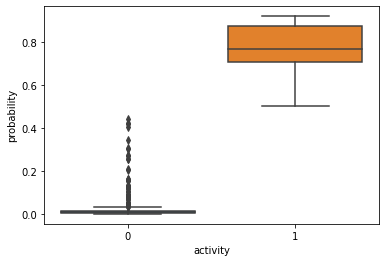

In [124]:
ax = sns.boxplot(xgb_pred,xgb_prob[:,1])
ax.set(xlabel="activity",ylabel="probability")

Calculate a ROC AUC for our model

In [100]:
roc_auc_score(test.active,xgb_prob[:,1])

0.8683423099940156

This looks pretty good, now let's build a model with all of the antibiotic data. 

In [101]:
xgb_full = XGBClassifier()
x_full = np.array([x for x in ab_df.desc])
y_full = ab_df.active
xgb_full.fit(x_full,y_full)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=3,
              min_child_weight=1, missing=None, n_estimators=100, n_jobs=1,
              nthread=None, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)

Now that we have a model, we can use it to make som predictions on the Broad Institute's repurposing set.  First, we'll grab this set from the web. 

In [102]:
url = "https://s3.amazonaws.com/data.clue.io/repurposing/downloads/repurposing_samples_20180907.txt"
repurposing_df = pd.read_csv(url, comment = "!", sep="\t")

Let's take a look at the first few rows to see what's there. 

In [103]:
repurposing_df.head()

,broad_id,pert_iname,qc_incompatible,purity,vendor,catalog_no,vendor_name,expected_mass,smiles,InChIKey,pubchem_cid,deprecated_broad_id
0,BRD-K89787693-001-01-1,"[sar9,met(o2)11]-substance-p",0,NaN,Tocris,1178,2-({5-amino-2-[({1-[6-amino-2-({[1-(2-amino-5-...,"1,392.73",CC(C)C[C@H](NC(=O)CN(C)C(=O)[C@H](Cc1ccccc1)NC...,OUPXSLGGCPUZJJ-SARDKLJWSA-N,163829.0,NaN
1,BRD-K88956297-003-01-9,"1-((Z)-3-Chloroallyl)-1,3,5,7-tetraazaadamanta...",0,94.41,BidePharm,BD51690,"1-((Z)-3-Chloroallyl)-1,3,5,7-tetraazaadamanta...",215.106,Cl\C=C/C[N+]12CN3CN(CN(C3)C1)C2,LDLCEGCJYSDJLX-UPHRSURJSA-N,5846454.0,NaN
2,BRD-A86415025-050-01-0,"1-(1,2-Diphenylethyl)piperidine-(+/-)",0,98.04,Tocris,360,"(?)-1-(1,2-Diphenylethyl)piperidine maleate",265.183,C(C(N1CCCCC1)c1ccccc1)c1ccccc1,JQWJJJYHVHNXJH-UHFFFAOYSA-N,206666.0,NaN
3,BRD-A95802703-001-01-0,1-(2-chloro-5-methylphenoxy)-3-(isopropylamino...,0,92.38,Enamine,Z1672746675,1-(2-chloro-5-methylphenoxy)-3-(isopropylamino...,257.118,CC(C)NCC(O)COc1cc(C)ccc1Cl,NJEIOWSBPCZKTL-UHFFFAOYSA-N,20497006.0,NaN
4,BRD-K96055017-003-02-7,1-acetyl-4-methylpiperazine,0,90.28,Tocris,351,1-Acetyl-4-methylpiperazine hydrochloride,142.111,CN1CCN(CC1)C(C)=O,YSDBJKNOEWSFGA-UHFFFAOYSA-N,550758.0,NaN


As we saw in the previous notebook, the repurposing data contains duplicates and null values.  Let's get rid of these.

In [104]:
repurposing_df.drop_duplicates('smiles',inplace=True)
repurposing_df.dropna(axis=0,subset=['smiles'],inplace=True)

In [105]:
repurposing_df.shape

(6244, 12)

As above, use descriptastorus to calcualte descriptors

In [106]:
repurposing_desc_list = [generator.process(x) for x in tqdm(repurposing_df.smiles)]

In [107]:
repurposing_desc_ok = [x[0] for x in repurposing_desc_list]
pd.Series(repurposing_desc_ok).value_counts()

True    6244
dtype: int64

In [108]:
repurposing_df['desc'] = [x[1:] for x in repurposing_desc_list]

In [109]:
repurposing_df.head()

,broad_id,pert_iname,qc_incompatible,purity,vendor,catalog_no,vendor_name,expected_mass,smiles,InChIKey,pubchem_cid,deprecated_broad_id,desc
0,BRD-K89787693-001-01-1,"[sar9,met(o2)11]-substance-p",0,NaN,Tocris,1178,2-({5-amino-2-[({1-[6-amino-2-({[1-(2-amino-5-...,"1,392.73",CC(C)C[C@H](NC(=O)CN(C)C(=O)[C@H](Cc1ccccc1)NC...,OUPXSLGGCPUZJJ-SARDKLJWSA-N,163829.0,NaN,"[1.5818916260184153, 3220.1773701867137, 72.81..."
1,BRD-K88956297-003-01-9,"1-((Z)-3-Chloroallyl)-1,3,5,7-tetraazaadamanta...",0,94.41,BidePharm,BD51690,"1-((Z)-3-Chloroallyl)-1,3,5,7-tetraazaadamanta...",215.106,Cl\C=C/C[N+]12CN3CN(CN(C3)C1)C2,LDLCEGCJYSDJLX-UPHRSURJSA-N,5846454.0,NaN,"[1.8009625314016358, 230.2533564975087, 9.5960..."
2,BRD-A86415025-050-01-0,"1-(1,2-Diphenylethyl)piperidine-(+/-)",0,98.04,Tocris,360,"(?)-1-(1,2-Diphenylethyl)piperidine maleate",265.183,C(C(N1CCCCC1)c1ccccc1)c1ccccc1,JQWJJJYHVHNXJH-UHFFFAOYSA-N,206666.0,NaN,"[1.8288898030917446, 499.804163233686, 13.6231..."
3,BRD-A95802703-001-01-0,1-(2-chloro-5-methylphenoxy)-3-(isopropylamino...,0,92.38,Enamine,Z1672746675,1-(2-chloro-5-methylphenoxy)-3-(isopropylamino...,257.118,CC(C)NCC(O)COc1cc(C)ccc1Cl,NJEIOWSBPCZKTL-UHFFFAOYSA-N,20497006.0,NaN,"[2.41254152698502, 355.2727408671211, 12.83649..."
4,BRD-K96055017-003-02-7,1-acetyl-4-methylpiperazine,0,90.28,Tocris,351,1-Acetyl-4-methylpiperazine hydrochloride,142.111,CN1CCN(CC1)C(C)=O,YSDBJKNOEWSFGA-UHFFFAOYSA-N,550758.0,NaN,"[2.328221491209792, 127.5677964944704, 7.56047..."


Format the descriptors for model building

In [110]:
repurposing_x = np.array([x for x in repurposing_df.desc])

Predict activity for the repurposing set and put this into the dataframe. 

In [111]:
repurposing_pred = xgb_full.predict_proba(repurposing_x)

In [113]:
repurposing_df['pred'] = repurposing_pred[:,1]

Sort the dataframe by the predicted probabilities. 

In [115]:
repurposing_df.sort_values("pred",ascending=False,inplace=True)

In [116]:
repurposing_df.head()

,broad_id,pert_iname,qc_incompatible,purity,vendor,catalog_no,vendor_name,expected_mass,smiles,InChIKey,pubchem_cid,deprecated_broad_id,desc,pred
4129,BRD-A74980173-213-01-1,gatifloxacin,0,77.22,MicroSource,1504272,GATIFLOXACIN,375.159,COc1c(N2CCNC(C)C2)c(F)cc2c1n(cc(C(O)=O)c2=O)C1CC1,XUBOMFCQGDBHNK-UHFFFAOYSA-N,4872633.0,NaN,"[2.0312285638536896, 983.3041997140859, 19.292...",0.976365
8106,BRD-K62374253-001-07-8,rufloxacin,0,97.36,MicroSource,1502335,RUFLOXACIN HYDROCHLORIDE,363.105,CN1CCN(CC1)c1c(F)cc2c3c1SCCn3cc(C(O)=O)c2=O,NJCJBUHJQLFDSW-UHFFFAOYSA-N,4979271.0,NaN,"[1.9743414651959867, 935.1055962233459, 17.714...",0.967965
6632,BRD-A24228527-213-01-9,ofloxacin,0,98.67,MicroSource,1502044,OFLOXACIN,361.144,CC1COc2c(N3CCN(C)CC3)c(F)cc3c2n1cc(C(O)=O)c3=O,GSDSWSVVBLHKDQ-UHFFFAOYSA-N,3288597.0,NaN,"[2.004088915400979, 963.2881482992597, 18.5850...",0.966582
5246,BRD-K09471561-001-18-2,levofloxacin,0,97.70,MicroSource,1504260,LEVOFLOXACIN,361.144,C[C@H]1COc2c(N3CCN(C)CC3)c(F)cc3c2n1cc(C(O)=O)...,GSDSWSVVBLHKDQ-JTQLQIEISA-N,149096.0,NaN,"[2.004088915400979, 963.2881482992597, 18.5850...",0.966582
3468,BRD-K76534306-001-22-7,enrofloxacin,0,96.46,MicroSource,1503721,ENROFLOXACIN,359.165,CCN1CCN(CC1)c1cc2n(cc(C(O)=O)c(=O)c2cc1F)C1CC1,SPFYMRJSYKOXGV-UHFFFAOYSA-N,6957639.0,NaN,"[1.8342383024563755, 927.751757198637, 18.4219...",0.958741


Create a rank order column

In [117]:
repurposing_df['rank'] = range(0,repurposing_df.shape[0])

Add a molecule column to the dataframe so that we can do a substructure search. 

In [119]:
repurposing_df['mol'] = [Chem.MolFromSmiles(x) for x in tqdm(repurposing_df.smiles)]

Create a query molecule from Halicin

In [125]:
halicin = Chem.MolFromSmarts("Nc1nnc(Sc2ncc(s2)[N+]([O-])=O)s1")

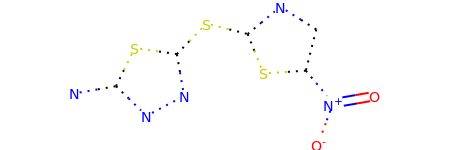

In [126]:
halicin

Do the substructure search and show the matching row. 

In [122]:
repurposing_df['match'] = [x.HasSubstructMatch(halicin) for x in tqdm(repurposing_df.mol)]
repurposing_df.query("match")

,broad_id,pert_iname,qc_incompatible,purity,vendor,catalog_no,vendor_name,expected_mass,smiles,InChIKey,pubchem_cid,deprecated_broad_id,desc,pred,rank,mol,match
8722,BRD-K32730239-001-01-0,SU3327,0,94.58,Tocris,3607,SU 3327,260.945,Nc1nnc(Sc2ncc(s2)[N+]([O-])=O)s1,NQQBNZBOOHHVQP-UHFFFAOYSA-N,11837140.0,NaN,"[2.1404489309233523, 494.32877134531054, 10.83...",0.046852,764,<rdkit.Chem.rdchem.Mol object at 0x7f22c9c956c0>,True


In this case, Halicin ranks 765, much lower than what we saw with ChemProp

In [127]:
def rebalance_data(df_in):
    df_active = df_in.query("active == 1")
    df_inactive = df_in.query("active == 0")
    df_active_upsample = resample(df_active,replace=True,n_samples=df_inactive.shape[0])
    df_upsample = df_inactive.append(df_active_upsample)
    return df_upsample